# Data Preprocessing Utilities
This notebook demonstrates useful transformations for bacterial microscopy time-lapse data.

In [49]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile
from skimage import exposure, transform, filters, util, morphology, feature, segmentation, measure
from scipy import ndimage

# Add the project root to the path so we can import our modules
project_root = Path(os.getcwd()).parent.parent
sys.path.append(str(project_root))

# Import our modules
try:
    from src.data.loader import DataLoader
    print("✓ Successfully imported DataLoader")
except ImportError as e:
    print(f"Warning: Could not import DataLoader: {e}")
    print("Will use direct file loading instead")


✓ Successfully imported DataLoader


In [50]:
# ## Configure Data Paths

# Define data paths directly
data_dir = Path(project_root) / 'data'
test_data_dir = data_dir / 'timelapse_data' / 'LB_data'
processed_dir = data_dir / 'processed'

# Create processed directory if it doesn't exist
processed_dir.mkdir(exist_ok=True, parents=True)

print(f"Project root: {project_root}")
print(f"Data directory: {data_dir}")
print(f"Test data directory: {test_data_dir}")
print(f"Test data exists: {test_data_dir.exists()}")

# Initialize the data loader
try:
    loader = DataLoader(test_data_dir)
    print(f"✓ Data loader initialized with: {test_data_dir}")
except Exception as e:
    print(f"Warning: Could not initialize data loader: {e}")
    loader = None




Project root: /Users/lucas/Documents/GitHub/ECT
Data directory: /Users/lucas/Documents/GitHub/ECT/data
Test data directory: /Users/lucas/Documents/GitHub/ECT/data/timelapse_data/LB_data
Test data exists: True
✓ Data loader initialized with: /Users/lucas/Documents/GitHub/ECT/data/timelapse_data/LB_data


In [51]:
 ## Load Test Data

# Load the original images
try:
    if loader is not None:
        original_images = loader.load_image_stack('original_images.tif')
        print(f"Original images loaded via DataLoader: {original_images.shape}, dtype: {original_images.dtype}")
    else:
        # Fallback: load directly with tifffile
        import tifffile
        original_images = tifffile.imread(test_data_dir / 'original_images.tif')
        print(f"Original images loaded directly: {original_images.shape}, dtype: {original_images.dtype}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print(f"Looking for file at: {test_data_dir / 'original_images.tif'}")
except Exception as e:
    print(f"Error loading images: {e}")

# ## Useful Transformations for Bacterial Microscopy Data

def display_comparison(original, transformed, title="Transformation", figsize=(12, 6)):
    """Display original and transformed images side by side"""
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(transformed, cmap='gray')
    axes[1].set_title(title)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Select a sample frame for demonstration
frame_idx = 0
try:
    if 'original_images' in locals() and original_images is not None:
        sample_frame = original_images[frame_idx]
        print(f"Sample frame selected: {sample_frame.shape}")
    else:
        print("Error: Original images not loaded correctly")
        sample_frame = None
except Exception as e:
    print(f"Error selecting sample frame: {e}")
    sample_frame = None

Original images loaded via DataLoader: (361, 841, 887), dtype: float32
Sample frame selected: (841, 887)


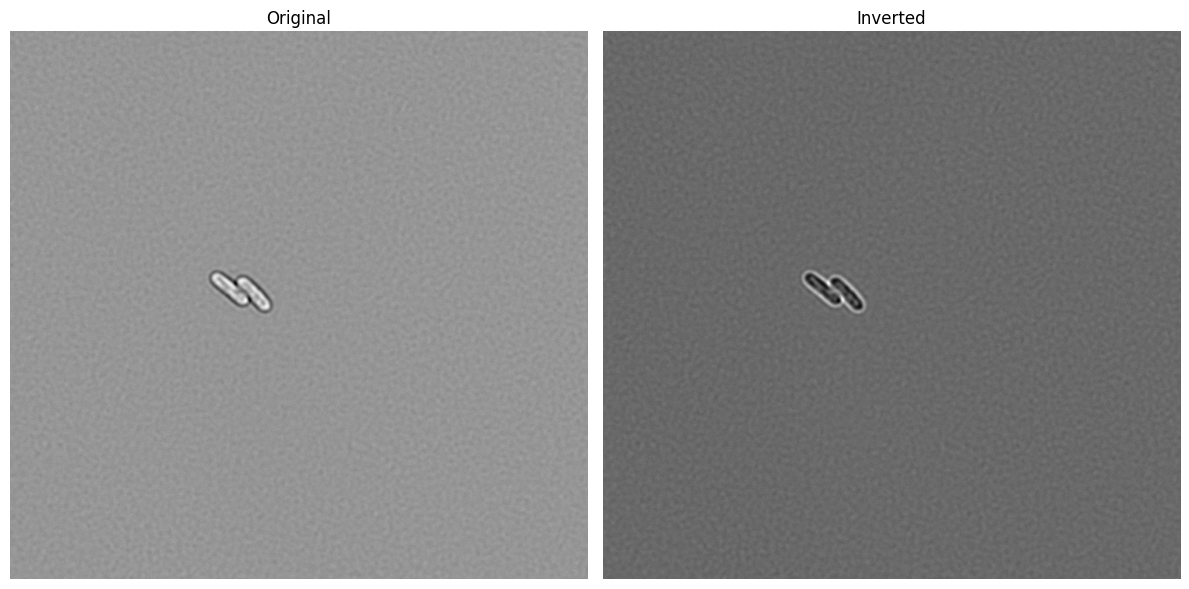

In [52]:
# 1. Image Inversion (useful for phase contrast)
def invert_image(image):
    """Invert image intensities"""
    return util.invert(image)

if sample_frame is not None:
    try:
        inverted = invert_image(sample_frame)
        display_comparison(sample_frame, inverted, "Inverted")
    except Exception as e:
        print(f"Error in image inversion: {e}")
else:
    print("Skipping image inversion - no sample frame available")

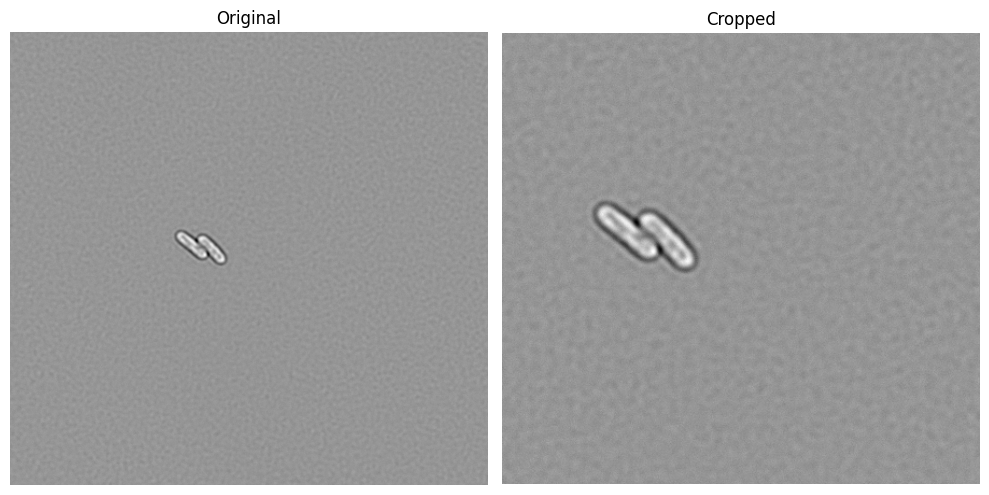

In [53]:
# 2. Cropping / ROI Selection
def crop_image(image, roi):
    """
    Crop image to region of interest
    
    Args:
        image: Input image
        roi: Tuple of (y_min, y_max, x_min, x_max)
    """
    y_min, y_max, x_min, x_max = roi
    return image[y_min:y_max, x_min:x_max]

if sample_frame is not None:
    try:
        # Example: Crop to center region
        h, w = sample_frame.shape
        center_roi = (h//4, 3*h//4, w//4, 3*w//4)
        cropped = crop_image(sample_frame, center_roi)
        
        # Display with different figsize due to different dimensions
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(sample_frame, cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(cropped, cmap='gray')
        plt.title('Cropped')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in image cropping: {e}")
else:
    print("Skipping image cropping - no sample frame available")

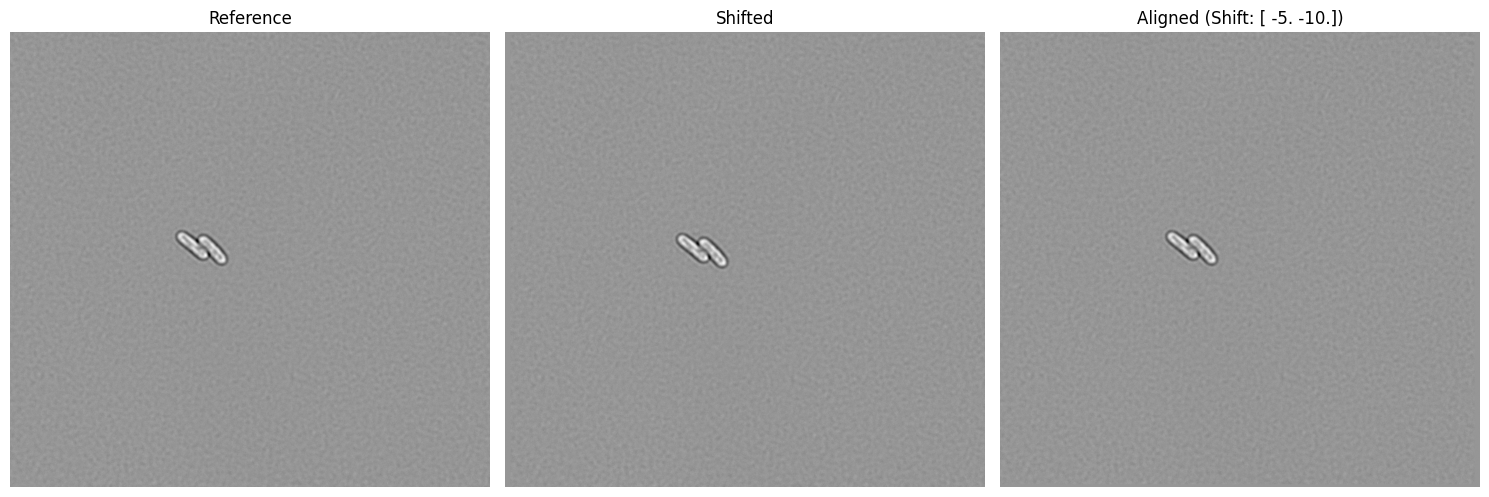

In [54]:
# 4. Frame Alignment / Registration
def align_frame(moving, reference, transformation='translation'):
    """
    Align a moving image to a reference image
    
    Args:
        moving: Moving image to be aligned
        reference: Reference image
        transformation: Type of transformation ('translation', 'rigid', 'similarity', 'affine')
    """
    from skimage.registration import phase_cross_correlation
    
    # Compute shift
    shift, error, diffphase = phase_cross_correlation(reference, moving)
    
    # Apply shift
    aligned = ndimage.shift(moving, shift, mode='constant', cval=0)
    
    return aligned, shift

if sample_frame is not None:
    try:
        # For demonstration, create a shifted version of the original
        shifted = ndimage.shift(sample_frame, (5, 10), mode='constant', cval=0)
        aligned, shift = align_frame(shifted, sample_frame)
        
        # Display comparison
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(sample_frame, cmap='gray')
        axes[0].set_title('Reference')
        axes[0].axis('off')
        
        axes[1].imshow(shifted, cmap='gray')
        axes[1].set_title('Shifted')
        axes[1].axis('off')
        
        axes[2].imshow(aligned, cmap='gray')
        axes[2].set_title(f'Aligned (Shift: {shift})')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in frame alignment: {e}")
else:
    print("Skipping frame alignment - no sample frame available")

In [55]:
# 5. Time Series Subsampling
def subsample_time_series(stack, interval=2):
    """
    Subsample time series by taking every nth frame
    
    Args:
        stack: Input image stack
        interval: Interval for subsampling
    """
    return stack[::interval]

if 'original_images' in locals() and original_images is not None:
    try:
        # For demonstration on a small subset
        if len(original_images) > 10:
            subset = original_images[:10]
            subsampled = subsample_time_series(subset, interval=2)
            print(f"Original subset: {subset.shape}")
            print(f"Subsampled: {subsampled.shape}")
    except Exception as e:
        print(f"Error in time series subsampling: {e}")
else:
    print("Skipping time series subsampling - no original images available")

Original subset: (10, 841, 887)
Subsampled: (5, 841, 887)


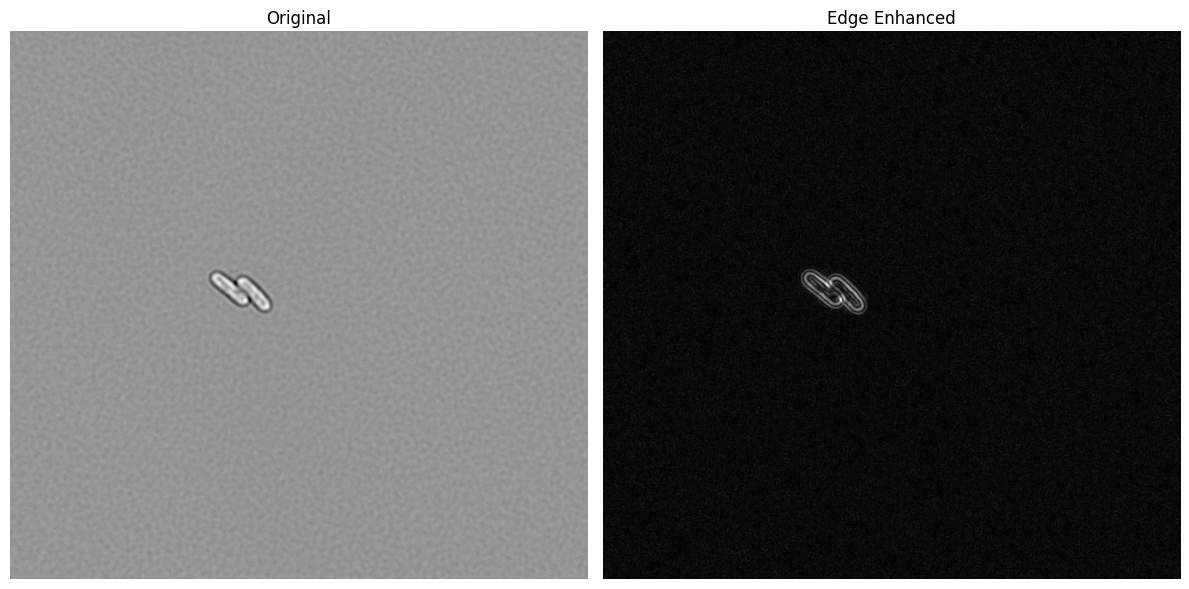

In [56]:
# 6. Edge Enhancement
def enhance_edges(image, sigma=1.0):
    """Enhance edges using a Sobel filter"""
    return filters.sobel(image)

if sample_frame is not None:
    try:
        edges = enhance_edges(sample_frame)
        display_comparison(sample_frame, edges, "Edge Enhanced")
    except Exception as e:
        print(f"Error in edge enhancement: {e}")
else:
    print("Skipping edge enhancement - no sample frame available")

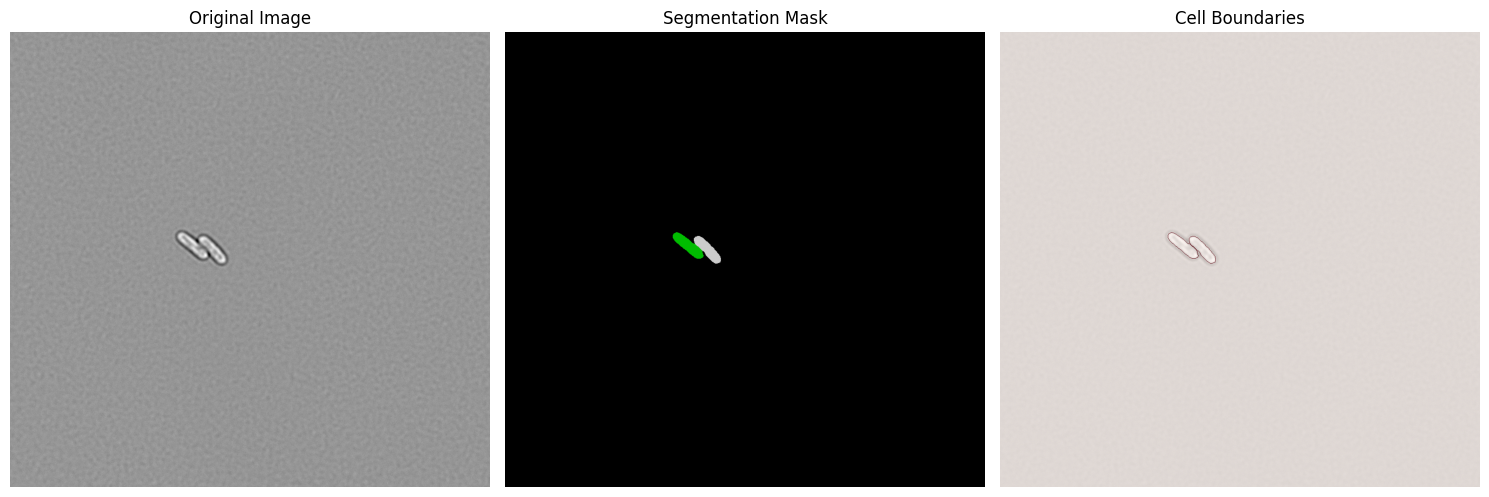

In [57]:
# 7. Boundary Extraction
def extract_boundaries(mask):
    """
    Extract boundaries from a labeled mask
    
    Args:
        mask: Labeled mask
    """
    boundaries = np.zeros_like(mask, dtype=bool)
    
    for i in range(1, mask.max() + 1):
        cell_mask = mask == i
        boundary = segmentation.find_boundaries(cell_mask, mode='inner')
        boundaries = np.logical_or(boundaries, boundary)
    
    return boundaries

try:
    # Try to load a mask for demonstration
    try:
        masks = loader.load_masks('masks.tif')
        sample_mask = masks[frame_idx]
        
        # Extract boundaries
        boundaries = extract_boundaries(sample_mask)
        
        # Display
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(sample_frame, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(sample_mask, cmap='nipy_spectral')
        axes[1].set_title('Segmentation Mask')
        axes[1].axis('off')
        
        axes[2].imshow(sample_frame, cmap='gray')
        axes[2].imshow(boundaries, cmap='Reds', alpha=0.7)
        axes[2].set_title('Cell Boundaries')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
    except FileNotFoundError:
        print("Mask file not found for boundary extraction demonstration")
except NameError:
    pass

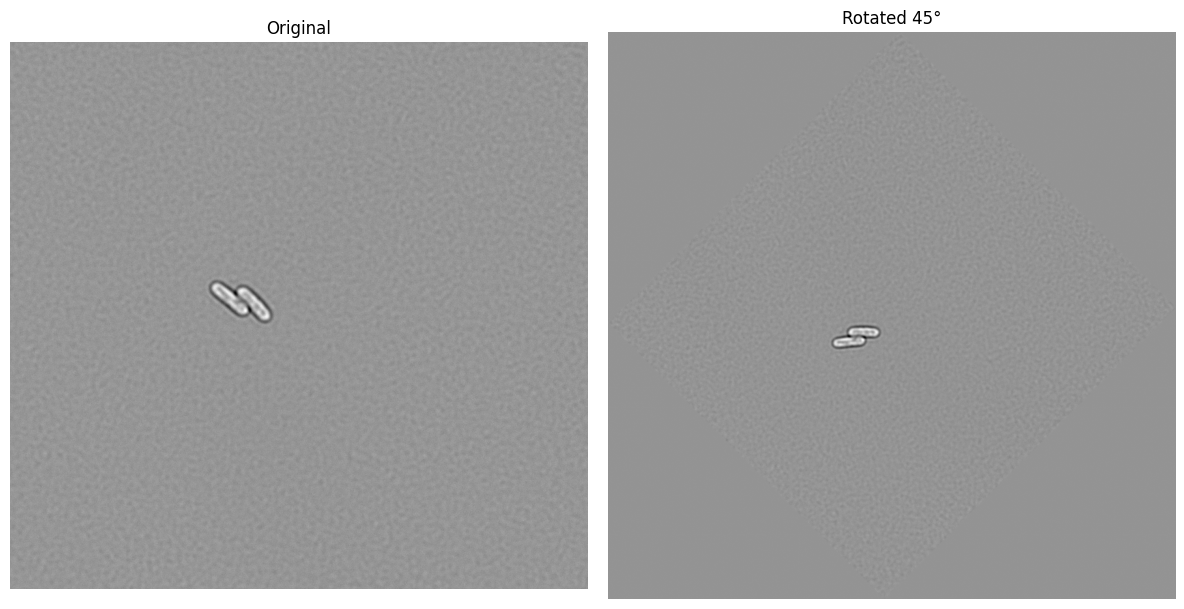

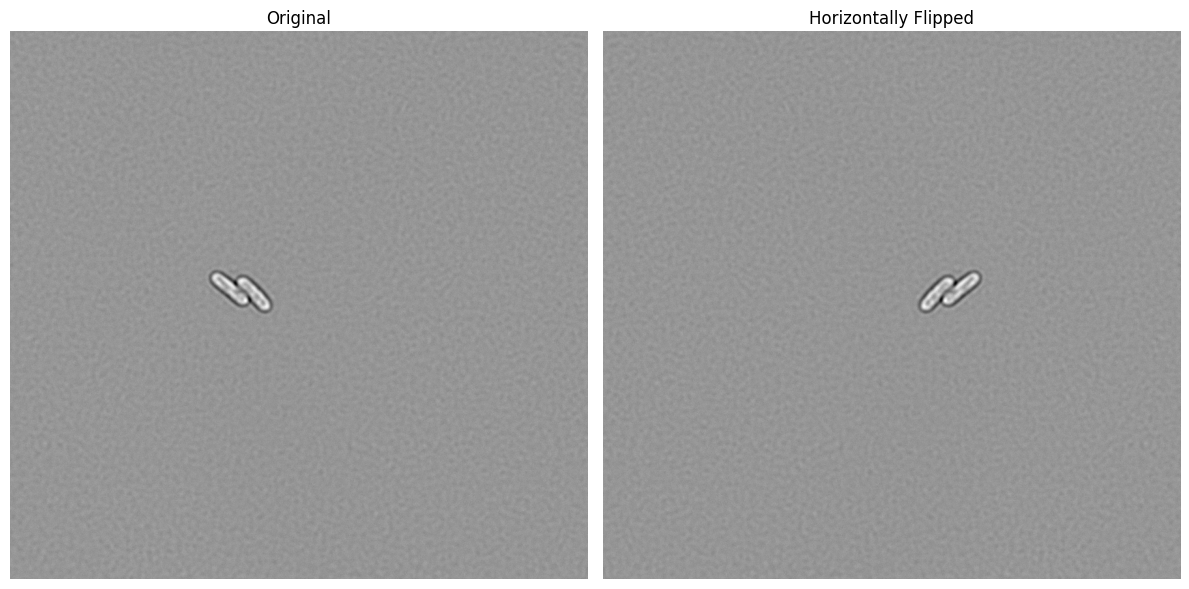

In [58]:
# 8. Image Rotation and Flipping
def rotate_image(image, angle=45):
    """Rotate image by angle in degrees"""
    return transform.rotate(image, angle, resize=True, mode='constant', cval=0)

def flip_image(image, direction='horizontal'):
    """Flip image horizontally or vertically"""
    if direction == 'horizontal':
        return np.fliplr(image)
    elif direction == 'vertical':
        return np.flipud(image)
    else:
        raise ValueError("Direction must be 'horizontal' or 'vertical'")

try:
    # Rotate
    rotated = rotate_image(sample_frame, angle=45)
    display_comparison(sample_frame, rotated, "Rotated 45°")
    
    # Flip
    flipped = flip_image(sample_frame, direction='horizontal')
    display_comparison(sample_frame, flipped, "Horizontally Flipped")
except NameError:
    pass

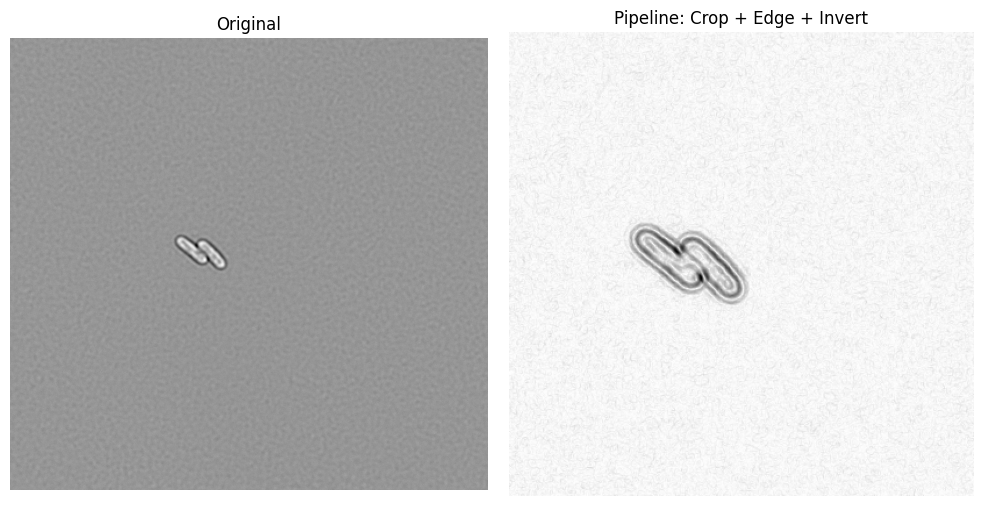

Applying inversion to 5-frame subset...
Processing: 0/5 frames
Processing: 1/5 frames
Processing: 2/5 frames
Processing: 3/5 frames
Processing: 4/5 frames
Processing complete: (5, 841, 887)


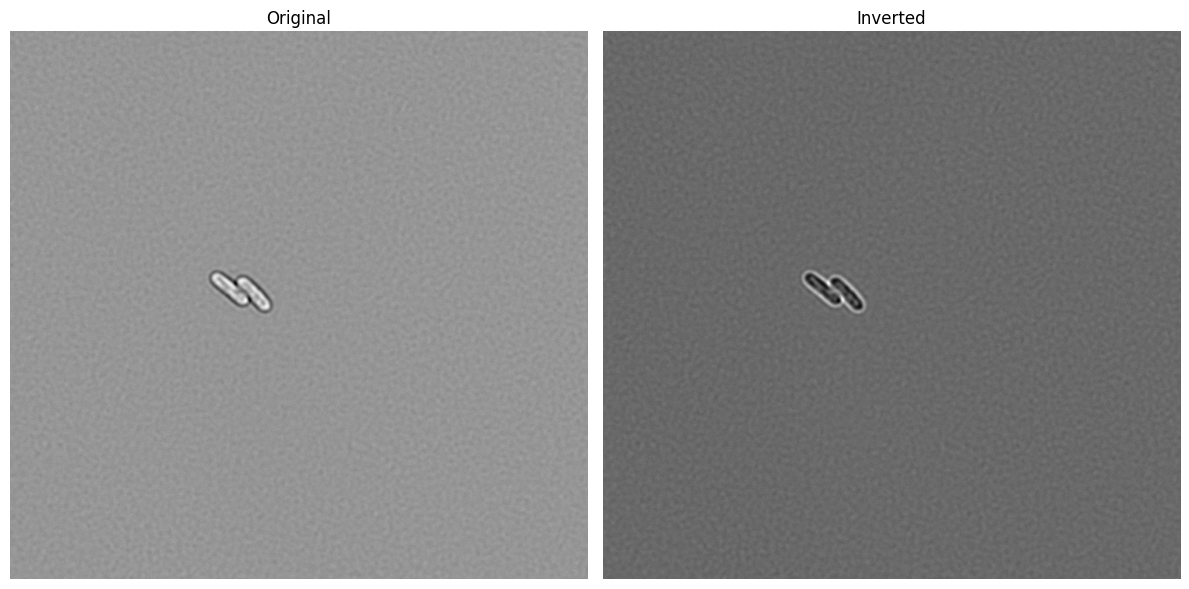

In [59]:
# 9. Multiple Transformation Pipeline
def apply_transformations(image, transformations):
    """
    Apply a pipeline of transformations to an image
    
    Args:
        image: Input image
        transformations: List of (function, kwargs) tuples
    """
    result = image.copy()
    
    for func, kwargs in transformations:
        result = func(result, **kwargs)
    
    return result

if sample_frame is not None:
    # Example pipeline: Crop, enhance edges, invert
    pipeline = [
        (crop_image, {'roi': (200, 600, 200, 600)}),
        (enhance_edges, {'sigma': 1.0}),
        (invert_image, {})
    ]
    
    transformed = apply_transformations(sample_frame, pipeline)
    
    # Display
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_frame, cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(transformed, cmap='gray')
    plt.title('Pipeline: Crop + Edge + Invert')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping transformation pipeline demo - no sample frame available")

# ## Apply Transformations to Stack

# Define a function to process entire stack
def process_stack(stack, transformation_func, **kwargs):
    """Apply transformation to each frame in a stack"""
    processed = np.zeros_like(stack)
    
    for i in range(stack.shape[0]):
        processed[i] = transformation_func(stack[i], **kwargs)
        
        # Print progress every 10%
        if i % max(1, stack.shape[0] // 10) == 0:
            print(f"Processing: {i}/{stack.shape[0]} frames")
    
    return processed

# Example: Apply a simple transformation to the entire stack
if original_images is not None:
    # Use a small subset for demonstration
    if len(original_images) > 5:
        subset = original_images[:5]
        
        # Apply inversion to entire stack
        print("Applying inversion to 5-frame subset...")
        inverted_stack = process_stack(subset, invert_image)
        print(f"Processing complete: {inverted_stack.shape}")
        
        # Display first frame before and after
        display_comparison(subset[0], inverted_stack[0], "Inverted")
    else:
        print("Not enough frames for stack processing demo")
else:
    print("Skipping stack processing demo - no images available")

# ## Save Transformed Data

def save_stack(stack, filename, output_dir=processed_dir):
    """Save image stack to file"""
    path = output_dir / filename
    tifffile.imwrite(path, stack)
    print(f"Saved to {path}")
    return path

# # Example: Save a transformed stack
# try:
#     # Check if we have processed data to save
#     if 'inverted_stack' in locals():
#         # For demonstration, save inverted subset
#         save_path = save_stack(inverted_stack, 'inverted_subset.tif')
        
#         # Create metadata
#         metadata = {
#             'original_shape': subset.shape,
#             'transformed_shape': inverted_stack.shape,
#             'transformation': 'inversion',
#             'pixel_size': data_config['physical_units']['pixel_size'],
#             'frame_interval': data_config['physical_units']['frame_interval']
#         }
        
#         # # Save metadata
#         # from src.utils.helpers import save_metadata
#         # metadata_path = processed_dir / 'inversion_metadata.json'
#         # save_metadata(metadata, metadata_path)
#         # print(f"Metadata saved to {metadata_path}")
# except NameError:
#     pass

# ## Conclusion

 This notebook demonstrates several useful transformations for bacterial microscopy data:

 1. Image Inversion - Convert between light and dark background
 2. Cropping/ROI Selection - Focus on relevant regions
 3. Background Correction - Remove uneven illumination
 4. Frame Alignment - Correct for drift or movement
 5. Time Series Subsampling - Reduce data size
 6. Edge Enhancement - Highlight cell boundaries
 7. Boundary Extraction - Extract cell outlines
 8. Rotation and Flipping - Adjust image orientation
 9. Transformation Pipeline - Apply multiple operations

These transformations can be applied to single frames or entire image stacks.